# Modelling - Transformed Data

## Import Cleaned Data

__DataFrames:__  
df_model - df with all the features (independent festures + Target)  
x - df with all independent features
y - df with dependent feature  
x_train - df with training data from x  
x_train_out - df with training data from x with outliers treatment applied  
x_test - df with test data from x  
x_test_out - df with test data from x with outliers treatment applied  



Nr of rows:
72538


<Figure size 432x288 with 0 Axes>

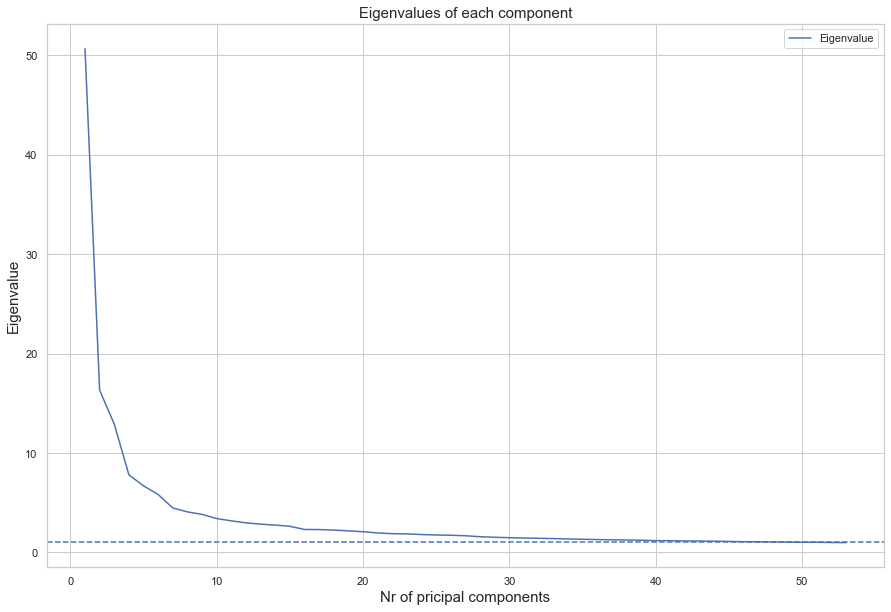

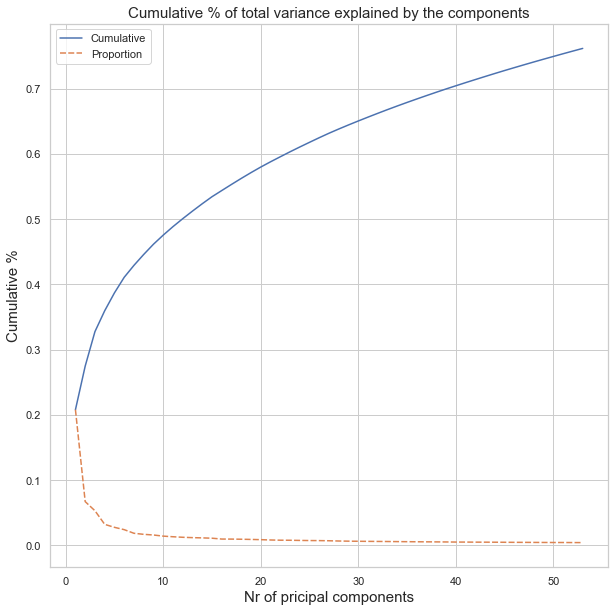

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001967


In [3]:
import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\Functions\Data-Science-Functions\Functions')
sys.path.insert(3, r'..\..\..')

import Visualizations_Functions as viz 
import Classification_CV as class_cv
import DataPreparation as preprocess 
import FeatureExtraction as ft_extract 
import DataScalling as scalling
import FeatureSelection as ft_selection
import importCleanedData as importData
import importCleanedData_Orig as importDataOrig
import importSubsets as subsets

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]


dir = r'..\..\..\SampleData\Sample'
df_model_skew,df_target = importData.importCleanedData_skew(dir=dir,)


#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = importData.splitData_(df_model_skew, date) 


#set columns
ratio_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Ratio'))]
shares_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Share'))]
margin_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Margin'))]
turnover_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Turnover'))]
dividend_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('dividend'))]


tran_component, test_components = importData.runPCA(x_train_out= x_train_out,x_test = x_test)



def import_folderData_csv_file (path):
    import os
    import glob
    import time 
    import pandas as pd 
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.DataFrame()
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp['file'] = file
        df = pd.concat([df, df_temp], axis=0)
        
        
    return(df)


#import subsets
lasso_subset_0, lasso_subset_15, mi_subset_0, mi_subset_15, lgb_subset, corr_subset0, corr_subset15 = subsets.importSubsets()

# __Grid Search__

## __Target 0.15__

#### Perfomance Metric: AUC and Precision

##### Set Metrics for GridSearch

In [39]:
from sklearn.metrics import make_scorer, precision_score
metrics = {"AUC": "roc_auc", "Precision": make_scorer(precision_score)}

#### Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = 0,
                               class_weight='balanced',)
params = {'max_depth':[2,4,6,8],
         'max_features':[2,3,4,5,6,7,8,9],
         'criterion':['gini','entropy'],
         'min_samples_leaf':[2,5,10,50,100]}

dt_gs_15 = class_cv.grid_search(model = model,
                    params = params,
                     x_train = x_train_out[subset_15],
                     y_train = y_train_dict['Target_0.15'],
                     x_val = x_test_out[subset_15],
                     y_val = y_test_dict['Target_0.15'],
                               metric = metrics,
                                n_splts=2,
                                refit = 'AUC')

Performing Grid Search
Perfomance metric {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score)}
Optimizing: DecisionTreeClassifier(class_weight='balanced', random_state=0)
Cross Validation: stratKfold
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.92      0.60      0.72     45103
        True       0.22      0.67      0.33      7467

    accuracy                           0.61     52570
   macro avg       0.57      0.64      0.53     52570
weighted avg       0.82      0.61      0.67     52570

[[26983 18120]
 [ 2434  5033]]
___________________________________________________________________________________________________________
  

##### Test GS

In [16]:
model = DecisionTreeClassifier(class_weight='balanced',
                               criterion='entropy',
                               max_depth=6,
                               max_features=9,
                               min_samples_leaf=10,
                               random_state=0)

dt_assess = class_cv.validateModel(x_train_out[lasso_subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
accuracy_train     0.608010
f1_train           0.328909
recall_train       0.675565
precision_train    0.217561
auc_train          0.636196
accuracy_test      0.596005
f1_test            0.311612
recall_test        0.637354
precision_test     0.209100
auc_test           0.613260
dtype: float64


#### Light Gradient Booster

In [7]:
model = lgb.LGBMClassifier(random_state = 0,
                               class_weight='balanced',)
params = {'max_depth':[2,4,6,8,10],
         'n_estimators':[10,50,100,200],
         'learning_rate':[0.001,0.05,0.1,0.2],
         'boosting_type':['gbdt','dart']}

lgb_gs_15 = class_cv.grid_search(model = model,
                    params = params,
                     x_train = x_train_out[subset_15],
                     y_train = y_train_dict['Target_0.15'],
                     x_val = x_test_out[subset_15],
                     y_val = y_test_dict['Target_0.15'],
                       metric = metrics,
                                n_splts=2,
                                refit = 'AUC')

Performing Grid Search
Perfomance metric {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score)}
Optimizing: LGBMClassifier(class_weight='balanced', random_state=0)
Cross Validation: stratKfold
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.92      0.62      0.74     45103
        True       0.22      0.66      0.33      7467

    accuracy                           0.62     52570
   macro avg       0.57      0.64      0.53     52570
weighted avg       0.82      0.62      0.68     52570

[[27882 17221]
 [ 2562  4905]]
___________________________________________________________________________________________________________
          

##### Test GS

In [4]:
model =  lgb.LGBMClassifier(boosting_type='dart',
                            class_weight='balanced',
                            learning_rate=0.2,
                            max_depth=2,
                            n_estimators=50,
                            random_state=0)

lgb_assess = class_cv.validateModel(x_train_out[subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
accuracy_train     0.622516
f1_train           0.332160
recall_train       0.660863
precision_train    0.221834
auc_train          0.638515
accuracy_test      0.616949
f1_test            0.326268
recall_test        0.640569
precision_test     0.223364
auc_test           0.626808
dtype: float64


#### Logistic Regression

In [8]:
model = LogisticRegression(random_state = 0,
                               class_weight='balanced',)
params = {'penalty' : ['l1', 'l2', 'elasticnet', None],
         'fit_intercept':[True, False],
         'solver':['lbfgs',
                   'newton-cg', 'newton-cholesky',
                   'sag', 'saga'],}

lr_gs_15 = class_cv.grid_search(model = model,
                    params = params,
                     x_train = x_train_out[subset_15],
                     y_train = y_train_dict['Target_0.15'],
                     x_val = x_test_out[subset_15],
                     y_val = y_test_dict['Target_0.15'],
                       metric = metrics,
                               n_splts=2,
                               refit = 'AUC')

Performing Grid Search
Perfomance metric {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score)}
Optimizing: LogisticRegression(class_weight='balanced', random_state=0)
Cross Validation: stratKfold
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.91      0.62      0.74     45103
        True       0.22      0.64      0.32      7467

    accuracy                           0.62     52570
   macro avg       0.56      0.63      0.53     52570
weighted avg       0.81      0.62      0.68     52570

[[27880 17223]
 [ 2706  4761]]
___________________________________________________________________________________________________________
      

##### Test GS

In [13]:
model = LogisticRegression(class_weight='balanced',
                          solver='newton-cholesky',
                          random_state=0,)
lr_assess = class_cv.validateModel(x_train_out[subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
accuracy_train     0.620988
f1_train           0.323448
recall_train       0.637784
precision_train    0.216670
auc_train          0.627996
accuracy_test      0.617006
f1_test            0.320086
recall_test        0.626378
precision_test     0.218636
auc_test           0.620921
dtype: float64


##### With Standartization

In [15]:
model = LogisticRegression(random_state = 0,
                               class_weight='balanced',)

#standardize data
x_train_stand, x_test_stand = scalling.standardize_2(x_train_out,x_test_out)
params = {'penalty' : ['l1', 'l2', 'elasticnet', None],
         'fit_intercept':[True, False],
         'solver':['lbfgs',
                   'newton-cg', 'newton-cholesky',
                   'sag', 'saga'],}

lr_gs_15 = class_cv.grid_search(model = model,
                    params = params,
                     x_train = x_train_stand[subset_15],
                     y_train = y_train_dict['Target_0.15'],
                     x_val = x_test_stand[subset_15],
                     y_val = y_test_dict['Target_0.15'],
                       metric = metrics,
                               n_splts=2,
                               refit = 'AUC')

Performing Grid Search
Perfomance metric {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score)}
Optimizing: LogisticRegression(class_weight='balanced', random_state=0)
Cross Validation: stratKfold
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.91      0.62      0.74     45103
        True       0.22      0.64      0.32      7467

    accuracy                           0.62     52570
   macro avg       0.56      0.63      0.53     52570
weighted avg       0.81      0.62      0.68     52570

[[27872 17231]
 [ 2705  4762]]
___________________________________________________________________________________________________________
      

In [16]:
model = LogisticRegression(class_weight='balanced', 
                           fit_intercept=False,
                           penalty='l1',
                           random_state=0,
                           solver='saga')
lr_assess = class_cv.validateModel(x_train_stand[subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
accuracy_train     0.553685
f1_train           0.314794
recall_train       0.721664
precision_train    0.201316
auc_train          0.623770
accuracy_test      0.547917
f1_test            0.314315
recall_test        0.717038
precision_test     0.203186
auc_test           0.618483
dtype: float64


#### Neural Network

#### MLP - SK-Learn

In [29]:
import imblearn.under_sampling as underSample
from sklearn.metrics import roc_auc_score
x_train_stand,x_test_stand = scalling.standardize_2(x_train_out[subset_15], x_test_out[subset_15])


undersampling_KNN = underSample.RepeatedEditedNearestNeighbours()
undersampling_random = underSample.RandomUnderSampler(random_state=0)
undersampling_centroids = underSample.ClusterCentroids(random_state=0)
undersampling_list = [undersampling_KNN,undersampling_random,undersampling_centroids]
undersampling_names = ['KNN_Under','Random_Under','Centroids_under']
assess_list = []

full_assess = pd.DataFrame()

for undersampling,underName in zip(undersampling_list,undersampling_names): 
    
    print(f'Testing: {underName}')
    x_under, y_under = undersampling.fit_resample(x_train_stand,y_train_dict['Target_0.15'])
    
    model = MLPClassifier( random_state=0,)
    nn_assess = class_cv.validateModel(x_under,
                        y_under,
                        model=model ,
                        scaler=True,
                            over_sampling=False,
                            predictions=False,
                            cv_type='stratKfold',
                            scaler_type='stand',
                            train_size=10,
                            test_size=1,
                            gap=0)
    
    pred= nn_assess['model'].predict(x_test_stand)
    pred_prob = nn_assess['model'].predict_proba(x_test_stand)[:,1]

    test_assess = pd.DataFrame(index = y_test.index)
    test_assess['True'] = y_test_dict['Target_0.15']
    test_assess['Pred'] = pred
    test_assess['Prob'] = pred_prob
    auc = roc_auc_score(test_assess['True'],test_assess['Pred'] )
    
    assess_dict = {}
    assess_dict['strategy'] = underName
    assess_dict['score'] = auc
    assess_list.append(assess_dict)
    
    
    scores = nn_assess['scores']
    scores['strategy'] = underName
    full_assess = pd.concat([full_assess,
                             scores],axis=0)
    
    print(f'AUC: {auc}')
    print(' ')
    print('-'*125)

Testing: KNN_Under
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.884040
f1_train           0.734182
recall_train       0.663988
precision_train    0.821653
auc_train          0.808986
accuracy_test      0.803805
f1_test            0.558010
recall_test        0.515755
precision_test     0.630421
auc_test           0.705565
dtype: float64
AUC: 0.571969209686396
 
-----------------------------------------------------------------------------------------------------------------------------
Testing: Random_Under
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.758195
f1_train           0.761983
recall_train       0.774729
precision_train    0.750322
auc_train          0.758196
accuracy_test      0.568370
f1_test            0.558935
recall_test        0.549761
precision_test     0.570094
auc_test           0.568374
dtype: float64
AUC: 0.5861092529374565
 
--------

In [38]:
strategies = pd.DataFrame.from_records(assess_list).set_index(['strategy'])
display(strategies)

,score
strategy,
KNN_Under,0.571969
Random_Under,0.586109
Centroids_under,0.562488


In [40]:
x_train_stand,x_test_stand = scalling.standardize_2(x_train_out[subset_15], x_test_out[subset_15])
undersampling_random = underSample.RandomUnderSampler(random_state=0)
x_under, y_under = undersampling.fit_resample(x_train_stand,
                                              y_train_dict['Target_0.15'])
model = MLPClassifier(random_state = 0,)

params = {'activation' : ['identity', 'logistic', 'tanh', 'relu'],
         'solver':['lbfgs', 'sgd', 'adam'],
         'learning_rate':['constant', 'invscaling', 'adaptive'],
         'batch_size':[64, 128, 256, 512],
         'learning_rate_init':[0.001,0.01,0.1],
         'max_iter':[10,50,100,]
         }

nn_gs_0 = class_cv.grid_search(model = model,
                    params = params,
                     x_train = x_under,
                     y_train = y_under,
                     x_val = x_test_stand,
                     y_val = y_test_dict['Target_0.15'],
                      metric = metrics,
                               n_splts=2,
                               refit = 'AUC')

Performing Grid Search
Perfomance metric {'AUC': 'roc_auc', 'Precision': make_scorer(precision_score)}
Optimizing: MLPClassifier(random_state=0)
Cross Validation: stratKfold
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       0.74      0.66      0.70      7467
        True       0.69      0.77      0.73      7467

    accuracy                           0.71     14934
   macro avg       0.72      0.71      0.71     14934
weighted avg       0.72      0.71      0.71     14934

[[4904 2563]
 [1698 5769]]
___________________________________________________________________________________________________________
                                        

##### Test GS

In [47]:
model = MLPClassifier(activation='logistic', batch_size=512, learning_rate='invscaling',
              learning_rate_init=0.1, max_iter=10, random_state=0,
              solver='sgd')


nn_assess = class_cv.validateModel(x_under,
                      y_under,
                      model=model ,
                      scaler=True,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

# nn_assess['scores'].mean()

stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.712691
f1_train           0.728052
recall_train       0.769207
precision_train    0.691083
auc_train          0.712691
accuracy_test      0.709313
f1_test            0.723812
recall_test        0.762568
precision_test     0.688979
auc_test           0.709316
dtype: float64


##### Set Network Architeture

In [4]:
def reset_random_seeds():
    import random
    from numpy.random import seed
    import os
    from tensorflow import random as r
    
    seed_nr = 0
    os.environ['PYTHONHASHSEED']=str(seed_nr)
    r.set_seed(seed_nr)
    np.random.seed(seed_nr)
    
    
def get_clf(meta, hidden_layer_sizes,activation_list, dropout, learning_rate_fn,opt):
    #get nr features in
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    
    opt = 'Adam'
    loss = 'BinaryCrossentropy'
    metrics = ['AUC','Recall','Precision']
    
    from scikeras.wrappers import KerasClassifier, KerasRegressor
    from tensorflow import keras
    model = keras.models.Sequential()
    #define input shape
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    
    #define hidden layers
    for hidden_layer_size, activation_ in zip(hidden_layer_sizes, activation_list):
        
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation_))
        model.add(keras.layers.Dropout(dropout))
    
    #define output layer
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(optimizer='Adam',
                  loss='BinaryCrossentropy',
                  metrics=metrics)
    
    
    return model

def genKerasNN(loss = 'binary_crossentropy',hidden_layer_sizes = (100,), activation_list = ['relu'],optimizer = 'Adam', 
               metrics = 'classif',batch_size = 500,epochs = 10, dropout = 0.1, class_weight = None,initial_learning_rate = 0.1):
    from scikeras.wrappers import KerasClassifier, KerasRegressor
    from tensorflow import keras
    from tensorflow.keras.optimizers.schedules import ExponentialDecay
    
    if metrics == 'classif':
        
        metrics_ = ['accuracy', 'AUC','Recall','Precision']
        print(metrics_)
        
        
    initial_learning_rate = initial_learning_rate
    decay_rate = 0.96
    decay_steps = 200

    learning_rate_fn = ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate)
    reset_random_seeds()
        
    model = KerasClassifier(
                            build_fn=get_clf,
                            hidden_layer_sizes=hidden_layer_sizes,
                            activation_list =activation_list ,
                            dropout=dropout,
                            batch_size= batch_size,
                            opt = optimizer,
                            # loss=loss,
                            metrics_=metrics_,
                            class_weight=class_weight,
                            learning_rate_fn = learning_rate_fn,
                            epochs= epochs,
                            validation_split=0.25
                            
                            )
    
    return(model)

metrics = ['AUC','Recall','Precision']
NNmodel =  genKerasNN(
                   hidden_layer_sizes = (10,),
                   activation_list = ['LeakyReLU',],
                   optimizer = 'Adam',
                   batch_size = 128,
                   epochs = 100,
                   dropout = 0.1,
                   class_weight = 'balanced',
                   initial_learning_rate = 0.01)


def gen_NNClassification (x, y, hidden_layer_sizes,activation_list, dropout,optimizer,loss = 'BinaryCrossentropy', metrics = ['AUC'],batch_size=180,epochs=10,validation_split = 0.25, class_weight = None, output_bias =None ):
    
    print('Neural Network Parameters:')
    print(f'Optimizer: {optimizer}')
    print(f'Loss: {loss}')
    print(f'Hidden Layer structure: {hidden_layer_sizes}')
    print(f'Acivation Functions: {activation_list}')
    print(f'Dropout: {dropout}')
    print(f'Class Weight: {class_weight}')
    print(f'Output Bias: {output_bias}')
    
    #import libraries
    from scikeras.wrappers import KerasClassifier, KerasRegressor
    from tensorflow import keras
    
    #get nr features in
    n_features_in_ = x.shape[1]
    n_classes_ = len(y.unique())
    
    reset_random_seeds()
    
    if output_bias is not None:
        output_bias =keras.initializers.Constant(output_bias)
    
    #set keras model
    model = keras.models.Sequential()
    
    #define input shape
    # model.add(keras.layers.Input(shape=(n_features_in_,)))
    model.add(keras.layers.Dense(
          4, activation='relu',
          input_shape=(n_features_in_,)))
    
    #define hidden layers
    for hidden_layer_size, activation_ in zip(hidden_layer_sizes,
                                              activation_list):
        
        model.add(keras.layers.Dense(hidden_layer_size,
                                     activation=activation_))
        
        model.add(keras.layers.Dropout(dropout))
    
    #define output layer
    model.add(keras.layers.Dense(1,
                                 activation="sigmoid",
                                 bias_initializer=output_bias))
    
    #compile model 
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics,
                  )
    
    #transform to SKlearn format
    NNmodel = KerasClassifier( model=model,
                            batch_size= batch_size,
                            epochs= epochs,
                            class_weight=class_weight,
                            validation_split=validation_split,
                            loss = loss)

    return NNmodel

['accuracy', 'AUC', 'Recall', 'Precision']


##### Grid Search

In [5]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

from sklearn.metrics import make_scorer, precision_score
metrics = {"AUC": "roc_auc", "Precision": make_scorer(precision_score)}

#standardize data
x_train_stand, x_test_stand = scalling.standardize_2(x_train_out,x_test_out)

params = {
  'hidden_layer_sizes': [(50,), (100,), (150,)],
  'dropout': [0.1, 0.2, 0.3],
  'epochs':[15,20,30],
  'batch_size':[32,64,180]
  
}

NNmodel =  genKerasNN(loss = 'binary_crossentropy',
                   activation_list = ['relu'],
#                    optimizer = optimizer,
                   class_weight = 'balanced',
                   initial_learning_rate = 0.01,
                   )

from sklearn.model_selection import GridSearchCV

NN_gs_15 = GridSearchCV(cv=2,
                        param_grid=params,
                        scoring=metrics,
                        estimator=NNmodel,
                        refit = 'AUC')

NN_gs_15.fit(x_train_stand[subset_15], 
             y_train)



['accuracy', 'AUC', 'Recall', 'Precision']
Epoch 1/15
617/617 [==============================] - 3s 4ms/step - loss: 0.6704 - auc: 0.6604 - recall: 0.6762 - precision: 0.2116 - val_loss: 0.6316 - val_auc: 0.6778 - val_recall: 0.6030 - val_precision: 0.2194
Epoch 2/15
617/617 [==============================] - 1s 2ms/step - loss: 0.6364 - auc: 0.7028 - recall: 0.6934 - precision: 0.2359 - val_loss: 0.6290 - val_auc: 0.6925 - val_recall: 0.5503 - val_precision: 0.2347
Epoch 3/15
617/617 [==============================] - 1s 2ms/step - loss: 0.6266 - auc: 0.7160 - recall: 0.7038 - precision: 0.2421 - val_loss: 0.6254 - val_auc: 0.6916 - val_recall: 0.6007 - val_precision: 0.2313
Epoch 4/15
617/617 [==============================] - 1s 2ms/step - loss: 0.6195 - auc: 0.7222 - recall: 0.7014 - precision: 0.2444 - val_loss: 0.6268 - val_auc: 0.6938 - val_recall: 0.6018 - val_precision: 0.2321
Epoch 5/15
617/617 [==============================] - 1s 2ms/step - loss: 0.6180 - auc: 0.7256 - reca

GridSearchCV(cv=2,
             estimator=KerasClassifier(activation_list=['relu'], batch_size=500, build_fn=<function get_clf at 0x000001892C07F4C0>, class_weight='balanced', dropout=0.1, epochs=10, hidden_layer_sizes=(100,), learning_rate_fn=<keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x0000018926889670>, opt='Adam', validation_split=0.25),
             param_grid={'batch_size': [32, 64, 180],
                         'dropout': [0.1, 0.2, 0.3], 'epochs': [15, 20, 30],
                         'hidden_layer_sizes': [(50,), (100,), (150,)]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'Precision': make_scorer(precision_score)})

In [6]:
print(NN_gs_15.best_estimator_)

KerasClassifier(
	model=None
	build_fn=<function get_clf at 0x000001892C07F4C0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.25
	shuffle=True
	run_eagerly=False
	epochs=15
	hidden_layer_sizes=(50,)
	activation_list=['relu']
	dropout=0.3
	opt=Adam
	learning_rate_fn=<keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay object at 0x000001894AE46C10>
	class_weight=balanced
)


##### Test GS

In [7]:
def reset_random_seeds():
    import random
    from numpy.random import seed
    import os
    from tensorflow import random as r
    
    seed_nr = 0
    os.environ['PYTHONHASHSEED']=str(seed_nr)
    r.set_seed(seed_nr)
    np.random.seed(seed_nr)

from numpy.random import seed
from tensorflow import keras 


reset_random_seeds()
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
loss_ = keras.losses.BinaryCrossentropy()
NNmodel = gen_NNClassification(x_train_stand[subset_15], 
                                 y_train_dict['Target_0.15'],
                                 hidden_layer_sizes = (50,),
                                 activation_list = ['relu'],
                                 dropout = 0.3,
                                 optimizer =optimizer ,
                                 loss = loss_, 
                                 metrics = ['AUC'],
                                 batch_size=64,
                                 epochs=15,
                                 validation_split = 0.25,
                                 class_weight = 'balanced',
                                 output_bias =None )

nn_assess = class_cv.validateModel(x_train_out[subset_15],
                      y_train_dict['Target_0.15'],
                      model=NNmodel ,
                      scaler=True,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=2,
                        test_size=1,
                        gap=0)



Neural Network Parameters:
Optimizer: <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x000001894A99B190>
Loss: <keras.losses.BinaryCrossentropy object at 0x000001894A99B5E0>
Hidden Layer structure: (50,)
Acivation Functions: ['relu']
Dropout: 0.3
Class Weight: balanced
Output Bias: None
stratKfold
Nr of splits: 2
Scalling will be performed at each iteration
Scaler type: stand
Epoch 1/15
309/309 [==============================] - 3s 6ms/step - loss: 0.6764 - auc: 0.6276 - val_loss: 0.6415 - val_auc: 0.6589
Epoch 2/15
309/309 [==============================] - 1s 2ms/step - loss: 0.6548 - auc: 0.6743 - val_loss: 0.6368 - val_auc: 0.6714
Epoch 3/15
309/309 [==============================] - 1s 2ms/step - loss: 0.6454 - auc: 0.6870 - val_loss: 0.6317 - val_auc: 0.6779
Epoch 4/15
309/309 [==============================] - 1s 2ms/step - loss: 0.6392 - auc: 0.6943 - val_loss: 0.6287 - val_auc: 0.6830
Epoch 5/15
309/309 [==============================] - 1s 2ms/step - loss:

In [9]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

pred_test = nn_assess['model'].predict(x_test_stand[subset_15])

prec_test = precision_score(y_test_dict['Target_0.15'],
                            pred_test)
rec_test = recall_score(y_test_dict['Target_0.15'],
                        pred_test)
auc_test = roc_auc_score(y_test_dict['Target_0.15'],
                         pred_test)
print('Metrics:')
print(f'AUC: {auc_test}')
print(f'Precision: {prec_test}')
print(f'Recall: {rec_test}')



312/312 [==============================] - 0s 943us/step
Metrics:
AUC: 0.5943525476012181
Precision: 0.21279109011137362
Recall: 0.45954810495626824


## Compare the perfomance of SMOTE using Decision Tree

To assess the effectiveness of using SMOTE over-sampling technique, the perfomance of Decision Tree is compared with an without the use of SMOTE, setting class weight as balance for both. As we can see, the model with SMOTE performs worse when compared to the model without SMOTE having AUC scores of 0.579025 and 0.615357 and F1 of 0.280109 and 0.314922 respectively. For that reason SMOTE won't be used anymore throughout the project.

### With SMOTE

In [14]:
model =DecisionTreeClassifier(max_depth=6, max_features=9,
                       min_samples_leaf=10, random_state=0)

dt_assess = class_cv.validateModel(x_train_out[subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=True,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
SMOTE oversampling will be performed
accuracy_train     0.647231
f1_train           0.649077
recall_train       0.654788
precision_train    0.646369
auc_train          0.647231
accuracy_test      0.613354
f1_test            0.285162
recall_test        0.543367
precision_test     0.199271
auc_test           0.584160
dtype: float64


### Without SMOTE

In [15]:
model =DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_features=9,
                       min_samples_leaf=10, random_state=0)

dt_assess = class_cv.validateModel(x_train_out[subset_15],
                      y_train_dict['Target_0.15'],
                      model=model ,
                      scaler=False,
                        over_sampling=False,
                        predictions=False,
                        cv_type='stratKfold',
                        scaler_type='stand',
                        train_size=10,
                        test_size=1,
                        gap=0)

stratKfold
Nr of splits: 10
accuracy_train     0.610040
f1_train           0.328606
recall_train       0.671445
precision_train    0.218234
auc_train          0.635660
accuracy_test      0.589975
f1_test            0.307129
recall_test        0.632780
precision_test     0.204542
auc_test           0.607835
dtype: float64
